# Generating Fiber Samples

This program will take a sample target from the given COSMOS mosaic tile and smooth the object.
It will smooth as a function of the FWHM that is inputted.
Then it will graph the smoothed object and overplot the Mini-IFUs onto the smoothed target

#### Please Note that plotting in python has y axis starting from the top down

# Getting Set-up

First we need to be in the proper directory

In [1]:
cd /Users/RichardP/Research/FOBOS/py_FOBOS/

/Users/RichardP/research/fobos/py_FOBOS


Now we need to add all the package dependencies.

In [2]:
import numpy as np
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import scipy.ndimage.filters as ndimage
#This is the specific code
import gen_spec

Now we will upload the specific ACS Mosaic Tile fits file 

We wll also input the catalog information for all the objects in the COSMOS field

In [3]:
gen = gen_spec.gen_spectra('/Users/RichardP/Research/FOBOS/Samples/acs_I_030mas_088_sci.fits')
gen.catalog_info('/Users/RichardP/Research/FOBOS/Samples/photoz_vers2.0_010312_UltraVISTA2016.fits')

# Un-Smoothed

Now that we're all set we can begin to learn more about the data. 

First, we are going to look for a specific object with IMAG between 22.5 - 24.5. 

In [4]:
def sample_index():
    for i in range(0, 10):
        if gen.objects_Imag[i] > 22.5 and gen.objects_Imag[i] < 24.5:
            print(str(gen.objects_id[i]) + "_" + str(i) + ": " + str(gen.objects_Imag[i]))
sample_index()

1423982_2: 23.93
1423983_3: 24.27
1424243_8: 23.836
1424298_9: 23.664


The format of this is the "Id of the objects" + "The index of object in the whole list of targets". So it looks like index 2 with 23.93 Imag is a good fit. We will set that value to variable target_index which we will use later on. Now we want to graph the image to sanity check the object looks legit. We will also graph the overplotted Mini-IFUs where the blue circle is IFU0. IFU 1 is the orange fraction and it goes clockwise.

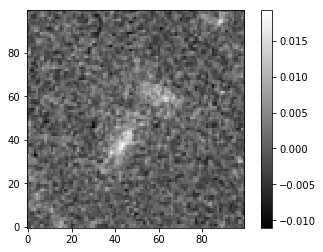

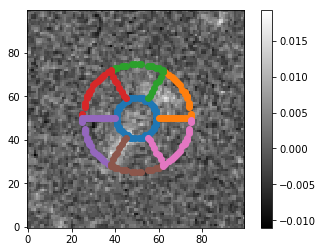

In [5]:
gen.target_index = 2
gen.target_image()
gen.graph_image(gen.box_image)
gen.border_plot()
gen.overplot_image(gen.box_image)

At first glance it looks like there is some object/galaxy there. However, The center of the galaxy seems fainter than the remnants so we'd be better off picking another. Number 9 with Imag 23. looks like a good choice.

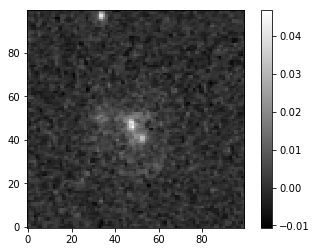

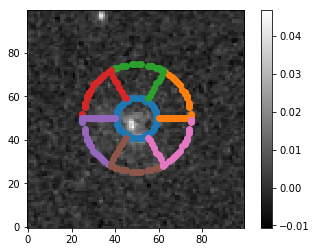

In [6]:
gen.target_index = 8
gen.target_image()
gen.graph_image(gen.box_image)
gen.border_plot()
gen.overplot_image(gen.box_image)

There looks to be a central galaxy with little evidence of remnants. This will help later one when we smooth the image to account for seeing. For now we want to grab some general information about the object such as the the RA and DEC and pixel (x,y) coordinates.

In [7]:
#Presenting the data in a more legible fashion
print(str(gen.objects_id[gen.target_index]) + "_RA: " + str(gen.objects_RA[gen.target_index]))
print(str(gen.objects_id[gen.target_index]) + "_DEC: " + str(gen.objects_DEC[gen.target_index]))
print(str(gen.objects_id[gen.target_index]) + "_XCoord: " + str(gen.x_coords[gen.target_index]))
print(str(gen.objects_id[gen.target_index]) + "_YCoord: " + str(gen.y_coords[gen.target_index]))

1424243_RA: 150.288
1424243_DEC: 2.58546
1424243_XCoord: 13039
1424243_YCoord: 15345


Now that we have the X,Y we want to create Mini-IFU plots to integrate our flux over. We'll double check that the first couple of pixels are right around the center of the plot. 

In [8]:
gen.overplotting()
for i in range(0, 5):
    print(str(gen.objects_id[gen.target_index]) + "_(X,Y)" + str(i) + ": (" + str(gen.fiber0_xcoords[
        gen.target_index * 293 + i]) + "," + str(gen.fiber0_ycoords[gen.target_index * 293 + i]) + ")")


1424243_(X,Y)0: (13039,15345)
1424243_(X,Y)1: (13040,15346)
1424243_(X,Y)2: (13041,15346)
1424243_(X,Y)3: (13042,15346)
1424243_(X,Y)4: (13043,15346)


The inner Mini-IFU has 293 pixels in total which is why I use 293. It looks as though the points are definitely around our target object. Now we're going to inspect the flux values of each Mini-IFU.

In [9]:
gen.Flux_Sum()

Mini-IFU0_Flux_1424243: 2.81656823066
Mini-IFU1_Flux_1424243: 0.199897444039
Mini-IFU2_Flux_1424243: 0.214047982103
Mini-IFU3_Flux_1424243: 0.73277288346
Mini-IFU4_Flux_1424243: 1.21495526942
Mini-IFU5_Flux_1424243: 1.50494895529
Mini-IFU6_Flux_1424243: 0.510777123876


These values are accurate in relation to the Mini-IFU overplot with purple and brown fractions being IFU 4 and 5. These two Mini-IFUs seem brighter than the rest and as a result the flux values are higher.  We will now integrate the flux really quickly.

In [10]:
gen.int_flux()

Int_Flux_1424243: 7.193967888845236


The catalog originally gave the values of the objects in magnitude and the relevant one is Imag since ACS uses the I-Band. We want to convert the integrated flux  and Mini-IFU flux values to ABMag just to look at. This value will be off by some factor because the catalog integrated over 3 arcseconds. 

In [11]:
gen.ABMAG_Convert(gen.IFU_sum)
for i in range(0,7):
    input = ( "self.IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.4326286986
1424243_IMag: 24.7769378918
1424243_IMag: 31.3906129622
1424243_IMag: 31.2196235869
1424243_IMag: 28.1430345786
1424243_IMag: 26.8789677507
1424243_IMag: 26.3438384506
1424243_IMag: 29.0452907546


For the 4th and 5th Imag values you notice that it is significantly lower than 1, 2, 3, and 6 which verifies that those fibers were indeed higher in counts. 

We know that Flux and Imag have a certain relationship that can be shown on a graph. We will now graph Flux vs. Imag and also Calculated Imag vs Objects_Imag. This way we see if our conversions are correct for the most part. 

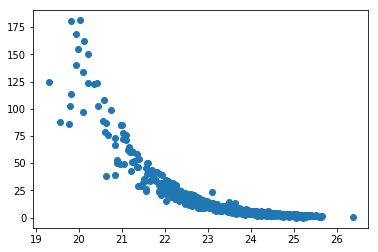

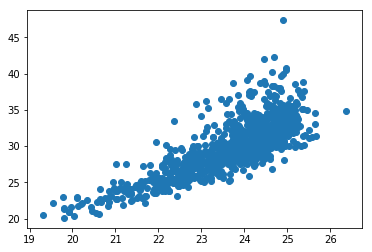

In [12]:
plt.scatter(gen.objects_Imag, gen.IFU_sum)
plt.show(1)
plt.scatter(gen.objects_Imag, gen.ABMAG_list)
plt.show(2)

The relation between Objects_Imag and Flux seems somewhat apparent. The Objects_Imag and the calculated Imag seems less linear as we'd hope. However, the relationship is very strong at small Objects_Imag and tails off as Imag gets greater which may be due to fainter objects being harder to observe and record. 

# Smoothed

We will now look at the smoothed data. 

First we will smooth the data in general. We will first specify smoothing with a FWHM of .5 arcseconds.

In [13]:
FWHM = .5
gen.smoothing(FWHM)

Now we will plot the image to sanity check that the image is the same and does indeed look smoothed

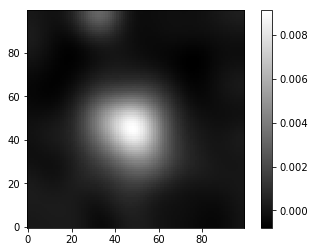

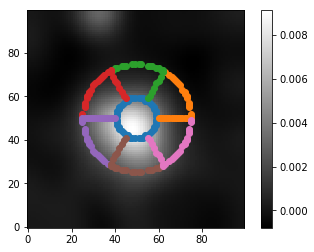

In [14]:
gen.graph_image(gen.smoothed_image)
gen.overplot_image(gen.smoothed_image)

The smoothing process looks okay so far, but let us pull up the information gathered about the objects such as Flux values.

In [15]:
gen.smooth_flux()

0.5_Smoothed_IFU_Flux0_1424243: 2.838628616882488
0.5_Smoothed_IFU_Flux1_1424243: 0.20267585841929758
0.5_Smoothed_IFU_Flux2_1424243: 0.24955701390234708
0.5_Smoothed_IFU_Flux3_1424243: 0.7372141461764841
0.5_Smoothed_IFU_Flux4_1424243: 1.1745591717772186
0.5_Smoothed_IFU_Flux5_1424243: 1.6055485043907538
0.5_Smoothed_IFU_Flux6_1424243: 0.5049993451975752
0.5_Smoothed_IFU_sum_1424243: 7.313182656746164


For this object the smoothing made the integrated flux greater because the object was already so narrowly focused when it was un-smoothed. 

We will now convert the flux into Imags.

In [16]:
gen.ABMAG_Convert(gen.smoothed_IFU_sum)
for i in range(0,7):
    input = ("self.smoothed_IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.3915394954
1424243_IMag: 24.7574332674
1424243_IMag: 31.3561042345
1424243_IMag: 30.835905596
1424243_IMag: 28.1279280636
1424243_IMag: 26.9635036422
1424243_IMag: 26.1820722891
1424243_IMag: 29.0737312687


As expected there was marginal difference adn the values were aligned with what we got before.

We expect seeing to vary from .5 - 1.5 for good observation runs. We will vary the FWHM by .25 arcsecond intervals to track the difference in calculations and images.

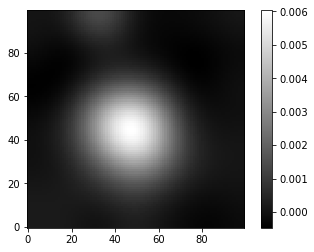

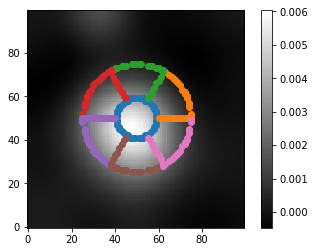

In [17]:
FWHM = .75
gen.smoothing(FWHM)
gen.graph_image(gen.smoothed_image)
gen.overplot_image(gen.smoothed_image)

In [18]:
gen.smooth_flux()

0.75_Smoothed_IFU_Flux0_1424243: 2.8534659689757973
0.75_Smoothed_IFU_Flux1_1424243: 0.2072343936215475
0.75_Smoothed_IFU_Flux2_1424243: 0.31154073464404064
0.75_Smoothed_IFU_Flux3_1424243: 0.7415729468152676
0.75_Smoothed_IFU_Flux4_1424243: 1.1570136793889105
0.75_Smoothed_IFU_Flux5_1424243: 1.6192161972867325
0.75_Smoothed_IFU_Flux6_1424243: 0.5013554656179622
0.75_Smoothed_IFU_sum_1424243: 7.391399386350258


In [19]:
gen.ABMAG_Convert(gen.smoothed_IFU_sum)
for i in range(0,7):
    input = ("self.smoothed_IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.3649432048
1424243_IMag: 24.7443999407
1424243_IMag: 31.3004978778
1424243_IMag: 30.2812988528
1424243_IMag: 28.113190265
1424243_IMag: 27.0011302246
1424243_IMag: 26.1608803945
1424243_IMag: 29.091835696


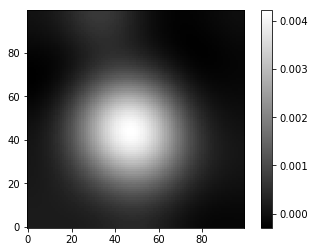

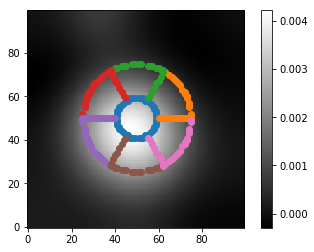

In [20]:
FWHM = 1
gen.smoothing(FWHM)
gen.graph_image(gen.smoothed_image)
gen.overplot_image(gen.smoothed_image)

In [21]:
gen.smooth_flux()

1_Smoothed_IFU_Flux0_1424243: 2.8623555744998157
1_Smoothed_IFU_Flux1_1424243: 0.21276726039900495
1_Smoothed_IFU_Flux2_1424243: 0.3708554364743577
1_Smoothed_IFU_Flux3_1424243: 0.7483114300266607
1_Smoothed_IFU_Flux4_1424243: 1.144521206151694
1_Smoothed_IFU_Flux5_1424243: 1.6350025264546275
1_Smoothed_IFU_Flux6_1424243: 0.49822343728737906
1_Smoothed_IFU_sum_1424243: 7.47203687129354


In [22]:
gen.ABMAG_Convert(gen.smoothed_IFU_sum)
for i in range(0,7):
    input = ("self.smoothed_IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.337816814
1424243_IMag: 24.7366236196
1424243_IMag: 31.2346268649
1424243_IMag: 29.8455932813
1424243_IMag: 28.0905759962
1424243_IMag: 27.0282699303
1424243_IMag: 26.1366250288
1424243_IMag: 29.1075024861


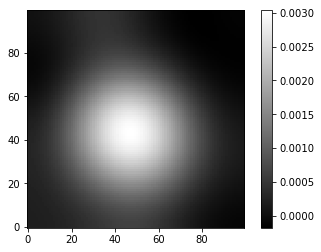

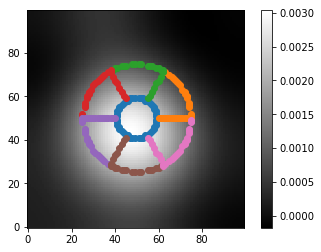

In [23]:
FWHM = 1.25
gen.smoothing(FWHM)
gen.graph_image(gen.smoothed_image)
gen.overplot_image(gen.smoothed_image)

In [24]:
gen.smooth_flux()

1.25_Smoothed_IFU_Flux0_1424243: 2.8671682570129633
1.25_Smoothed_IFU_Flux1_1424243: 0.2182839486690682
1.25_Smoothed_IFU_Flux2_1424243: 0.41985616463375663
1.25_Smoothed_IFU_Flux3_1424243: 0.7562710708007216
1.25_Smoothed_IFU_Flux4_1424243: 1.1353344472590834
1.25_Smoothed_IFU_Flux5_1424243: 1.654441213933751
1.25_Smoothed_IFU_Flux6_1424243: 0.49542461812961847
1.25_Smoothed_IFU_sum_1424243: 7.546779720438963


In [25]:
gen.ABMAG_Convert(gen.smoothed_IFU_sum)
for i in range(0,7):
    input = ("self.smoothed_IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.3129335399
1424243_IMag: 24.7324237211
1424243_IMag: 31.1706322701
1424243_IMag: 29.5353436316
1424243_IMag: 28.0641244223
1424243_IMag: 27.048417716
1424243_IMag: 26.107077611
1424243_IMag: 29.1215860771


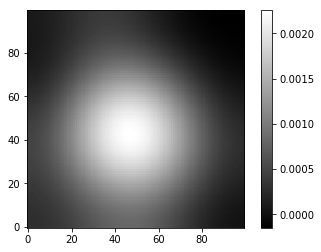

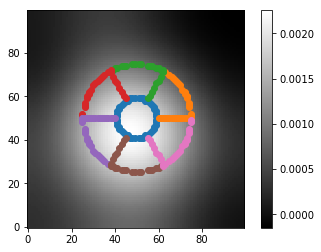

In [26]:
FWHM = 1.5
gen.smoothing(FWHM)
gen.graph_image(gen.smoothed_image)
gen.overplot_image(gen.smoothed_image)

In [27]:
gen.smooth_flux()

1.5_Smoothed_IFU_Flux0_1424243: 2.868792084045708
1.5_Smoothed_IFU_Flux1_1424243: 0.22351910580380263
1.5_Smoothed_IFU_Flux2_1424243: 0.4603686648015639
1.5_Smoothed_IFU_Flux3_1424243: 0.7647683941759169
1.5_Smoothed_IFU_Flux4_1424243: 1.1283355331979692
1.5_Smoothed_IFU_Flux5_1424243: 1.6762475094292313
1.5_Smoothed_IFU_Flux6_1424243: 0.49303718633018434
1.5_Smoothed_IFU_sum_1424243: 7.6150684777843765


In [28]:
gen.ABMAG_Convert(gen.smoothed_IFU_sum)
for i in range(0,7):
    input = ("self.smoothed_IFU_flux" + str(i))
    gen.ABMAG_Convert(input)

1424243_IMag: 22.2904134558
1424243_IMag: 24.7310082415
1424243_IMag: 31.1113818628
1424243_IMag: 29.305055066
1424243_IMag: 28.0361915121
1424243_IMag: 27.0638769844
1424243_IMag: 26.0743417283
1424243_IMag: 29.1336626006
